# Google Play Store Apps
## by Harutaka Kawamura

## Preliminary Wrangling

## Dataset overview
While many public datasets (on Kaggle and the like) provide Apple App Store data, there are not many counterpart datasets available for Google Play Store apps anywhere on the web. On digging deeper, I found out that iTunes App Store page deploys a nicely indexed appendix-like structure to allow for simple and easy web scraping. On the other hand, Google Play Store uses sophisticated modern-day techniques (like dynamic page load) using JQuery making scraping more challenging.

You can download the dataset [here](https://www.kaggle.com/lava18/google-play-store-apps/home)

In [83]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import warnings

sb.set()
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [84]:
df = pd.read_csv('data/googleplaystore.csv')
df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6614,Blood Pressure Tracker,MEDICAL,4.0,11,1.8M,"1,000+",Free,0,Everyone,Medical,"November 8, 2017",1.1.1,4.0 and up
4915,"AC Air condition Troubleshoot,Repair,Maintenance",BOOKS_AND_REFERENCE,4.2,27,3.1M,"5,000+",Free,0,Everyone,Books & Reference,"February 7, 2018",1.1,4.0 and up
5682,Neuvaines et prières au Coeur Sacré de Jésus,LIFESTYLE,NaN,17,3.7M,"5,000+",Free,0,Everyone,Lifestyle,"September 5, 2017",1.1,4.0 and up
10143,EZ TV Player,VIDEO_PLAYERS,3.5,51,11M,"10,000+",Free,0,Everyone,Video Players & Editors,"June 26, 2018",8.0.9,5.0 and up
4984,Apps Ads Detector,TOOLS,3.5,315,8.3M,"100,000+",Free,0,Everyone,Tools,"February 19, 2018",25,4.0.3 and up


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


### What is the structure of your dataset?
Typical table structure

### What is/are the main feature(s) of interest in your dataset?
Rating, Reviews, Installs

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
Price, Genres, Category, Size

## Cleaning

In [86]:
# change the column names to make it easier to handle this dataset
new_columns = ['app_name', 'category', 'rating', 'reviews', 'size', 'installs', 'type', 'price', 
            'content_rating', 'genres', 'last_updated', 'current_ver', 'android_ver']

df.columns = new_columns
df.head(1)

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


### Fix row with incorrect values

In [87]:
# The row below has incorrect values in each column.
regex = '([a-zA-Z]+) (\d+), (\d+)'
invalid_idx = ~df['last_updated'].str.contains(regex)
df[invalid_idx]

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [88]:
# I have to shift values in each column to the right and fill category with NaN
idx = df[invalid_idx].index[0]
cols = df.columns
for i in reversed(range(1, len(cols) - 1)):
    df.set_value(idx, cols[i + 1], df.iloc[idx][cols[i]])
df.set_value(idx, cols[1], np.nan)
df[invalid_idx]

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,NaN,1.9,19,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up


### Convert `reviews` to integer

In [89]:
df['reviews'] = df['reviews'].astype(int)
df['reviews'].dtype

dtype('int64')

### Convert `last_update` to datetime

In [90]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df['last_updated'].dtype

dtype('<M8[ns]')

### Covert `category` and `genres` to lower case

In [91]:
for col in ['category', 'genres']: df[col] = df[col].str.lower()
df.sample(5)

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
6039,Remote for Samsung TV & BluRay Players (Read D...,tools,3.3,1988,7.3M,"500,000+",Free,0,Everyone,tools,2018-08-03,Cow V3.15,4.3 and up
2836,ASUS Gallery,photography,4.3,125259,Varies with device,"50,000,000+",Free,0,Everyone,photography,2018-08-02,Varies with device,Varies with device
7295,CG Samanya Gyan,family,4.2,145,4.1M,"10,000+",Free,0,Teen,education,2017-09-12,7.2,2.3 and up
4184,Offroad Car H,family,4.2,1960,87M,"100,000+",Free,0,Everyone,simulation,2017-10-06,1.4,2.3 and up
1853,Choices: Stories You Play,game,4.6,807338,93M,"10,000,000+",Free,0,Teen,simulation,2018-07-30,2.3.5,4.0.3 and up


### Convert `installs` to int

In [92]:
df['installs'] = df['installs'].str.replace(',', '')
df['installs'] = df['installs'].str.replace('+', '')
df['installs'] = df['installs'].astype(int)
df.sample(5)

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
5778,ByssWeather for Wear OS,weather,4.2,19666,Varies with device,1000000,Free,0,Everyone,weather,2018-04-11,Varies with device,Varies with device
3487,Microsoft Translator,productivity,4.6,209696,49M,5000000,Free,0,Everyone,productivity,2018-06-18,3.2.258b ae1da5165,4.3 and up
8817,DS router,tools,3.8,253,15M,50000,Free,0,Everyone,tools,2018-06-13,1.1.8,4.1 and up
1481,At home - rental · real estate · room finding ...,house_and_home,3.8,2496,Varies with device,500000,Free,0,Everyone,house & home,2018-07-05,Varies with device,Varies with device
10538,FK Sarajevo,sports,NaN,6,26M,100,Free,0,Everyone,sports,2018-03-02,1.0,4.1 and up


### Convert `size` to MB
Expand values such as 12M or 24K

In [93]:
def parse_size(size_str):
    if 'varies with device' == size_str.lower():
        return np.nan
    else:
        num_regex = r'\d+\.\d+|\d+'
        abbr_regex = r'[a-zA-Z]'
        conv_dict = {'K': 1e3, 'M': 1e6}
        num = re.search(num_regex, size_str).group(0)
        abbr = re.search(abbr_regex, size_str).group(0)
        return float(num) * conv_dict[abbr.upper()]

df['size'] = df['size'].apply(parse_size) / 1e6
df.sample(5)

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
6160,CARS.bg,auto_and_vehicles,4.5,276,1.7,100000,Free,0,Everyone,auto & vehicles,2017-07-05,1.1.3,4.4 and up
6961,Benefit Extras Mobile App,health_and_fitness,2.3,3,2.4,1000,Free,0,Everyone,health & fitness,2018-07-18,6.0,5.0 and up
5207,AI with Python Tutorial,family,4.4,8,3.3,5000,Free,0,Everyone,education,2018-06-05,1.0.4,4.1 and up
4840,Z-Empire: Dead Strike,family,4.6,99,19.0,10000,Free,0,Teen,strategy,2018-06-08,1.8.7,4.0.3 and up
9135,love sms good morning,communication,4.2,10,3.1,5000,Free,0,Everyone,communication,2016-04-28,1.0,2.3 and up


### Convert `price` to float

In [94]:
regex = r'(\d+\.\d+|\d+)'
df['price'] = df['price'].str.extract(regex).astype(float)
df[df['price'] > 0]

,app_name,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
234,TurboScan: scan documents and receipts in PDF,business,4.7,11442,6.800,100000,Paid,4.99,Everyone,business,2018-03-25,1.5.2,4.0 and up
235,Tiny Scanner Pro: PDF Doc Scan,business,4.8,10295,39.000,100000,Paid,4.99,Everyone,business,2017-04-11,3.4.6,3.0 and up
290,TurboScan: scan documents and receipts in PDF,business,4.7,11442,6.800,100000,Paid,4.99,Everyone,business,2018-03-25,1.5.2,4.0 and up
291,Tiny Scanner Pro: PDF Doc Scan,business,4.8,10295,39.000,100000,Paid,4.99,Everyone,business,2017-04-11,3.4.6,3.0 and up
427,Puffin Browser Pro,communication,4.0,18247,NaN,100000,Paid,3.99,Everyone,communication,2018-07-05,7.5.3.20547,4.1 and up
476,"Moco+ - Chat, Meet People",dating,4.2,1545,NaN,10000,Paid,3.99,Mature 17+,dating,2018-06-19,2.6.139,4.1 and up
477,Calculator,dating,2.6,57,6.200,1000,Paid,6.99,Everyone,dating,2017-10-25,1.1.6,4.0 and up
478,Truth or Dare Pro,dating,NaN,0,20.000,50,Paid,1.49,Teen,dating,2017-09-01,1.0,4.0 and up
479,"Private Dating, Hide App- Blue for PrivacyHider",dating,NaN,0,0.018,100,Paid,2.99,Everyone,dating,2017-07-25,1.0.1,4.0 and up
480,Ad Blocker for SayHi,dating,NaN,4,1.200,100,Paid,3.99,Teen,dating,2018-08-02,1.2,4.0.3 and up


### Remove duplicates in `app_name`

In [95]:
df['app_name'].value_counts().head(10)

ROBLOX                                                9
CBS Sports App - Scores, News, Stats & Watch Live     8
8 Ball Pool                                           7
ESPN                                                  7
Duolingo: Learn Languages Free                        7
Candy Crush Saga                                      7
Bleacher Report: sports news, scores, & highlights    6
Sniper 3D Gun Shooter: Free Shooting Games - FPS      6
Bubble Shooter                                        6
Subway Surfers                                        6
Name: app_name, dtype: int64

In [96]:
df = df.drop_duplicates('app_name', keep='first')
df['app_name'].value_counts().head(10)

A Manual of Acupuncture                                    1
N1.RU - Real estate: apartments, new buildings, lodging    1
Cambridge English FC                                       1
U Launcher Lite – FREE Live Cool Themes, Hide Apps         1
CB Mobile                                                  1
CI Capital - Dynamic                                       1
fi                                                         1
KFC CZ                                                     1
Genius Scan - PDF Scanner                                  1
eBay Kleinanzeigen for Germany                             1
Name: app_name, dtype: int64

### Remove junk apps

In [97]:
df[df['price'] > 100][['app_name', 'reviews', 'category', 'price']]

,app_name,reviews,category,price
4197,most expensive app (H),6,family,399.99
4362,💎 I'm rich,718,lifestyle,399.99
4367,I'm Rich - Trump Edition,275,lifestyle,400.00
5351,I am rich,3547,lifestyle,399.99
5354,I am Rich Plus,856,family,399.99
5355,I am rich VIP,411,lifestyle,299.99
5356,I Am Rich Premium,1867,finance,399.99
5357,I am extremely Rich,41,lifestyle,379.99
5358,I am Rich!,93,finance,399.99
5359,I am rich(premium),472,finance,399.99


There are so many apps named "I'm rich" which are too expansive. I'll remove these junk apps.

In [98]:
df = df[~df['app_name'].str.lower().str.contains(r'(i|i\'m).*rich')]
df = df[~df['app_name'].str.lower().str.contains('most expensive app')]
df = df[~df['app_name'].str.lower().str.contains(('eu sou rico'))]
df[df['price'] > 100][['app_name', 'reviews', 'category', 'price']]

,app_name,reviews,category,price
6624,BP Fitness Lead Scanner,0,events,109.99
6692,cronometra-br,0,productivity,154.99
9719,EP Cook Book,0,medical,200.00


### Add `reviews_log`, `installs_log` columns
Add these columns to make it eaiser to plot them

In [99]:
df['reviews_log'] = np.log10(1 + df['reviews'])
df['installs_log'] = np.log10(1 + df['installs'])

# sort column order
cols = df.columns.tolist()
cols.insert(cols.index('reviews') + 1, cols.pop(cols.index('reviews_log')))
cols.insert(cols.index('installs') + 1, cols.pop(cols.index('installs_log')))

df = df.ix[:, cols]

df.sample(1)

,app_name,category,rating,reviews,reviews_log,size,installs,installs_log,type,price,content_rating,genres,last_updated,current_ver,android_ver
8899,DU Launcher - Boost Your Phone,personalization,4.5,67707,4.83064,4.8,1000000,6.0,Free,0.0,Everyone,personalization,2016-02-07,1.8.0.4,4.0 and up


## Storing
Save the cleaned dataset.

In [100]:
save_path = 'data/googleplaystore_cleaned.csv'
df.to_csv(save_path, index=False)

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [101]:
df = pd.read_csv(save_path)

### category

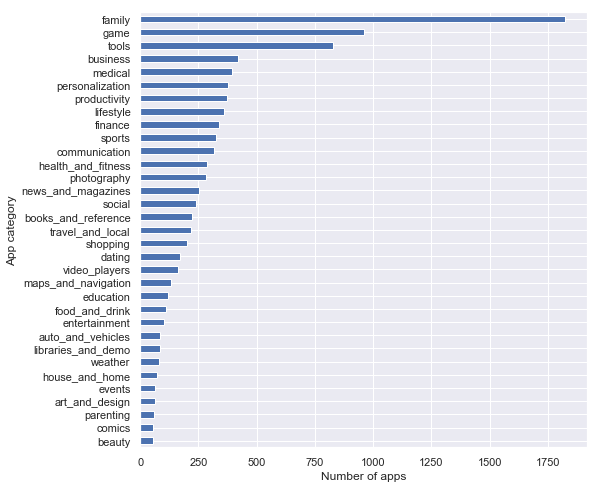

In [102]:
total = df['category'].value_counts().sort_values()
top10_categories = [x for x in total.index[-10:]]
total.plot.barh(figsize=(8, 8), color='b')
plt.xlabel('Number of apps')
plt.ylabel('App category');

- `family` is the most popular cateogry

### ratings

Percentage of apps rated higher than 4: 65.0 %


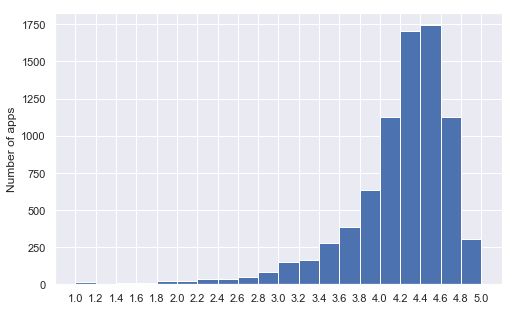

In [137]:
bins = np.arange(1, 5.1, 0.2)
df['rating'].plot.hist(bins=bins)
plt.xticks(bins)
plt.ylabel('Number of apps')
print('Percentage of apps rated higher than 4:', (df['rating'] >= 4.0).mean().round(2) * 100, '%')

- 65% of apps in this dataset is rated higher than 4.0

### reviews

In [104]:
print('Max', df['reviews'].max(), df['reviews_log'].max())
print('Min', df['reviews'].min(), df['reviews_log'].min())

Max 78158306 7.892975143488082
Min 0 0.0


Text(0,0.5,'Number of apps')

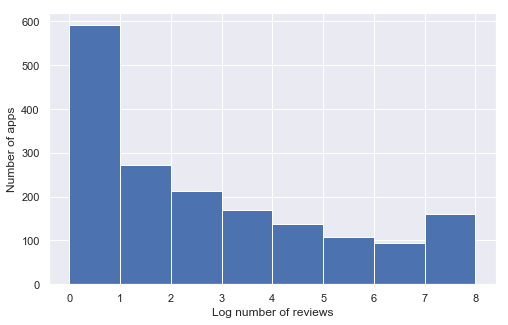

In [105]:
bins = np.arange(9)
df['reviews'].plot.hist(bins=bins)
plt.xlabel('Log number of reviews')
plt.ylabel('Number of apps')

- Skewed to the right
- The number of apps with more than 1M reviews is small

In [106]:
print('Apps with more than 10M reviews')
df[df['reviews_log'] > 7].sort_values('reviews', ascending=False)[['app_name', 'reviews', 'installs']]

Apps with more than 10M reviews


,app_name,reviews,installs
1999,Facebook,78158306,1000000000
300,WhatsApp Messenger,69119316,1000000000
2000,Instagram,66577313,1000000000
299,Messenger – Text and Video Chat for Free,56642847,1000000000
1370,Clash of Clans,44891723,100000000
3178,Clean Master- Space Cleaner & Antivirus,42916526,500000000
1354,Subway Surfers,27722264,1000000000
2905,YouTube,25655305,1000000000
6462,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999,500000000
1360,Clash Royale,23133508,100000000


- Obviously, well-known applictions have a lot of reviews

### Size

In [107]:
print('Max Size:', df['size'].max())
print('Min Size:', df['size'].min())

Max Size: 100.0
Min Size: 0.0085


Text(0,0.5,'Number of apps')

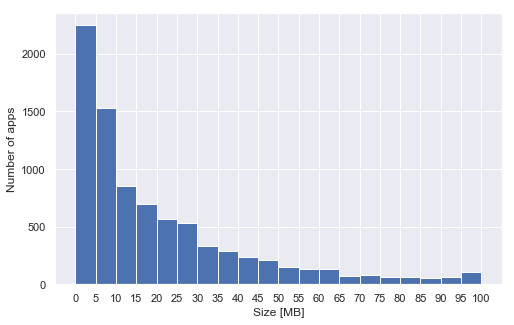

In [108]:
bins = np.arange(0, 101, 5)
df['size'].plot.hist(bins=bins)
plt.xlabel('Size [MB]')
plt.xticks(bins)
plt.ylabel('Number of apps')

- Most apps are larger than 1MB 

### installs

In [109]:
print('Min', df['installs'].min(), df['installs_log'].min())
print('Max', df['installs'].max(), df['installs_log'].max())

Min 0 0.0
Max 1000000000 9.000000000434293


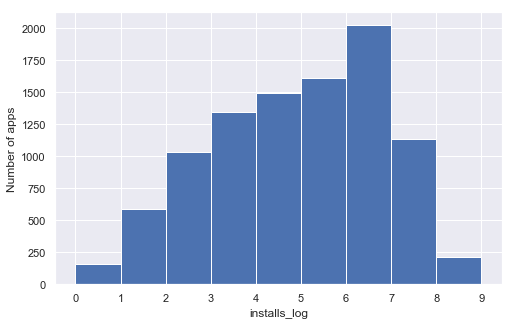

In [110]:
bins = np.arange(10)
# df.groupby(pd.cut(df['installs_log'], np.arange(10))).size().plot.bar(color='b')
df['installs_log'].plot.hist(bins=bins)
plt.xticks(bins)
plt.xlabel('installs_log')
plt.ylabel('Number of apps');

- Number of 

In [111]:
df[df['installs_log'] > 7].sort_values('installs_log', ascending=True).head(10)

,app_name,category,rating,reviews,reviews_log,size,installs,installs_log,type,price,content_rating,genres,last_updated,current_ver,android_ver
2598,Google Handwriting Input,tools,4.3,94427,4.975101,NaN,10000000,7.0,Free,0.0,Everyone,tools,2018-08-02,Varies with device,Varies with device
2978,"Pulse Nabd - World News, Urgent",news_and_magazines,4.5,357944,5.553816,12.0,10000000,7.0,Free,0.0,Everyone,news & magazines,2018-07-12,9.1,4.1 and up
3013,NYTimes - Latest News,news_and_magazines,3.9,63647,4.803785,23.0,10000000,7.0,Free,0.0,Everyone 10+,news & magazines,2018-08-01,6.19.5,4.4 and up
3019,Bloomberg: Market & Financial News,news_and_magazines,4.2,61692,4.790236,27.0,10000000,7.0,Free,0.0,Everyone,news & magazines,2018-07-25,5.9.1.1347176.a3ca6ab274,4.4 and up
3026,News Republic,news_and_magazines,4.3,479594,5.680875,18.0,10000000,7.0,Free,0.0,Teen,news & magazines,2018-07-28,9.2.3,4.0 and up
3027,Newsroom: News Worth Sharing,news_and_magazines,4.2,201737,5.304788,NaN,10000000,7.0,Free,0.0,Everyone 10+,news & magazines,2018-07-03,Varies with device,Varies with device
3028,SmartNews: Breaking News Headlines,news_and_magazines,4.2,233305,5.367926,3.1,10000000,7.0,Free,0.0,Everyone,news & magazines,2018-08-03,5.1.10,2.2 and up
3029,Updates for Samsung - Android Update Versions,news_and_magazines,4.0,80368,4.905089,NaN,10000000,7.0,Free,0.0,Everyone,news & magazines,2018-05-17,Varies with device,Varies with device
3034,Pocket,news_and_magazines,4.5,256680,5.409394,12.0,10000000,7.0,Free,0.0,Everyone,news & magazines,2018-07-24,6.7.15.7,4.0.3 and up
3039,"MapQuest: Directions, Maps, GPS & Navigation",maps_and_navigation,4.1,53481,4.728208,NaN,10000000,7.0,Free,0.0,Everyone,maps & navigation,2018-05-22,Varies with device,Varies with device


### type

In [112]:
df['type'].unique()

array(['Free', 'Paid', nan], dtype=object)

Ratio of free apps: 92.0 %


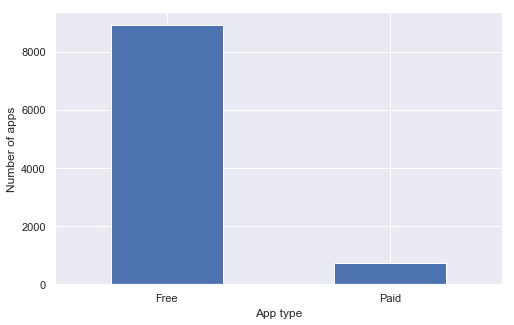

In [113]:
print('Ratio of free apps:', (df['type'] == 'Free').mean().round(2) * 100, '%')
df['type'].value_counts().plot.bar(color='b')
plt.xlabel('App type')
plt.ylabel('Number of apps')
plt.xticks(rotation=0);

- Approximately 92% of apps are free.

### price

(0, 700)

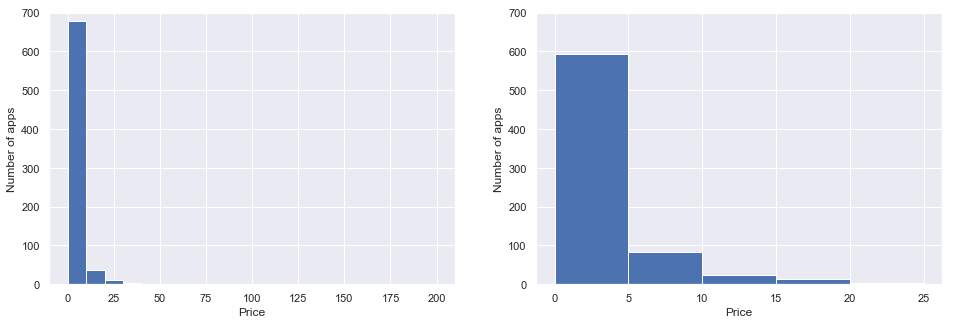

In [114]:
bins1 = np.arange(0, 201, 10)
bins2 = np.arange(0, 30, 5)
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 5)
df[df['price'] > 0]['price'].plot.hist(bins1, ax=ax1)
ax1.set_xlabel('Price')
ax1.set_ylabel('Number of apps')
ax1.set_ylim(0, 700)
df[df['price'] > 0]['price'].plot.hist(bins2, ax=ax2)
ax2.set_xlabel('Price')
ax2.set_ylabel('Number of apps')
ax2.set_ylim(0, 700)

- Most of apps are priced below $20.

### genres

Text(0,0.5,'Genres')

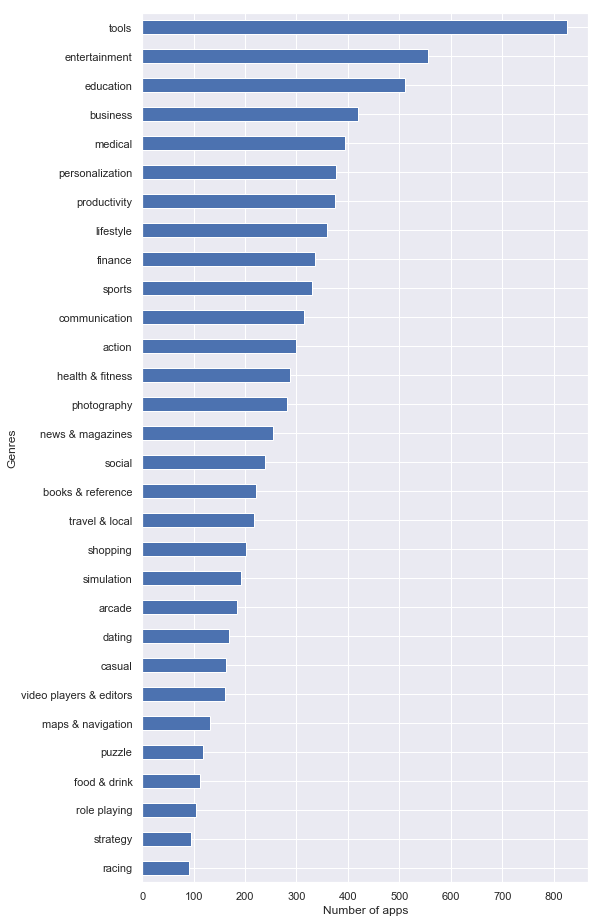

In [115]:
df['genres'].value_counts().sort_values(ascending=True).iloc[-30:].plot.barh(figsize=(8, 16), color='b')
plt.xlabel('Number of apps')
plt.ylabel('Genres')

- `tools` is the most popular genre

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

## category & type

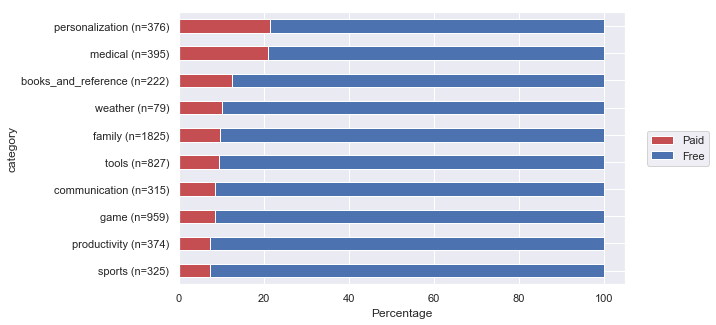

In [116]:
perc = df.groupby(['category', 'type']).size().unstack().fillna(0)
perc = perc.apply(lambda x: 100 * x / x.sum(), axis=1).sort_values('Paid').iloc[-10:, ::-1]
perc.plot.barh(stacked=True, color=['r', 'b'], figsize=(8, 5))
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center right')
locs, labels = plt.yticks()
new_labels = ['{} (n={})'.format(label.get_text(), df.groupby('category').size()[label.get_text()]) for label in labels]
plt.yticks(locs, new_labels);
plt.xlabel('Percentage');

`n` in y ticklabels represents the number of apps in the category

- `medical` and `personalization` have a lot more paid apps than free apps (more than 20%)

## category & price

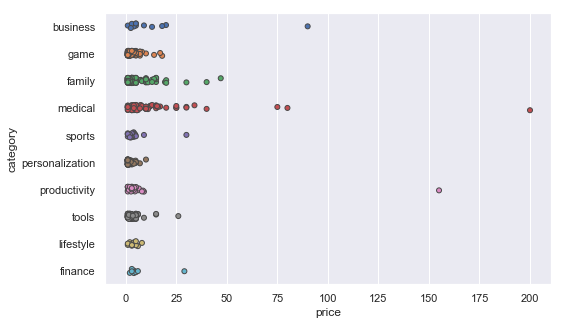

In [124]:
df_subset = df[df['price'] > 0][df['category'].isin(top10_categories)]
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sb.stripplot(x='price', y='category', data=df_subset, jitter=True, linewidth=1)

- Most of apps are priced below 50.
- `medical` and `family` apps tend to have a high price.

## rating & reviews

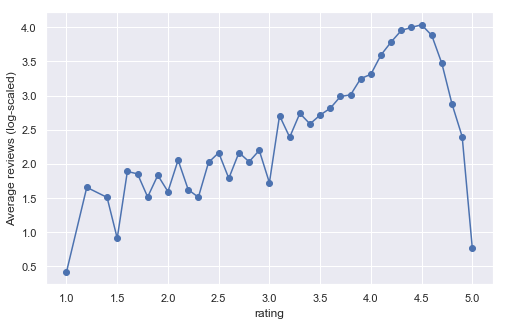

In [118]:
df.groupby('rating').mean()['reviews_log'].plot(marker='o')
plt.ylabel('Average reviews (log-scaled)');

- App with high ratings tend to have a lot of reviews.

## reviews & installs

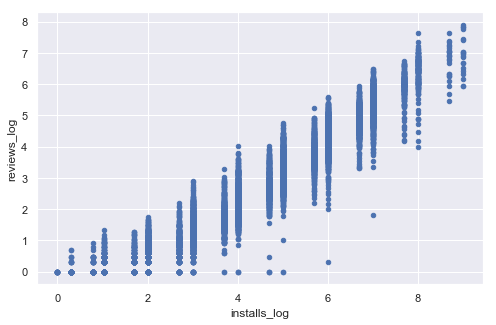

In [123]:
df.plot.scatter('installs_log', 'reviews_log');

- A positive correlation between `installs` and `reviews`
- People tend to install apps with 

## category & size

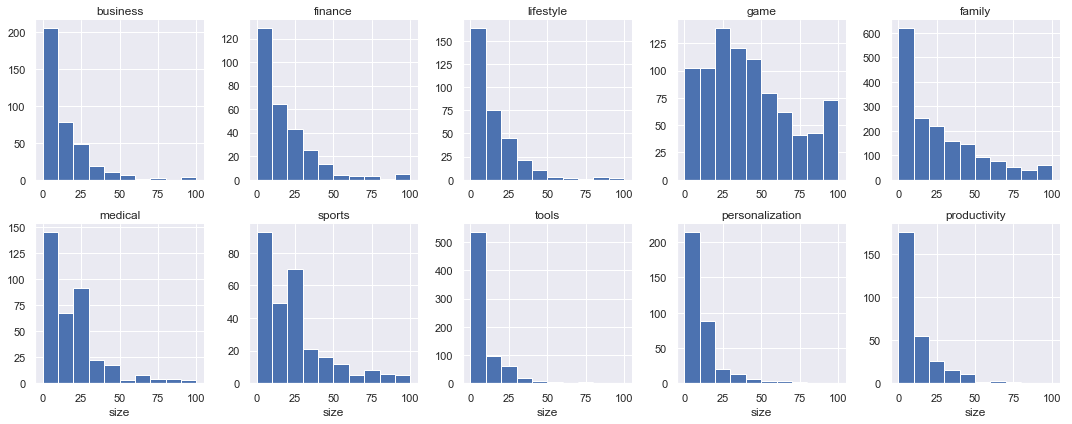

In [120]:
df_subset = df[df['category'].isin(top10_categories)]
bins = np.arange(0, 101, 10)
g = sb.FacetGrid(df_subset, col='category', col_wrap=5, sharex=False, sharey=False)
g = (g.map(plt.hist, 'size', bins=bins)).set_titles('{col_name}')

- In most categories, app sizes skew to the right
- `game` has a unique distribution. This is probably because games need large file size to implement a lot of features.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

## rating & installs & reviews

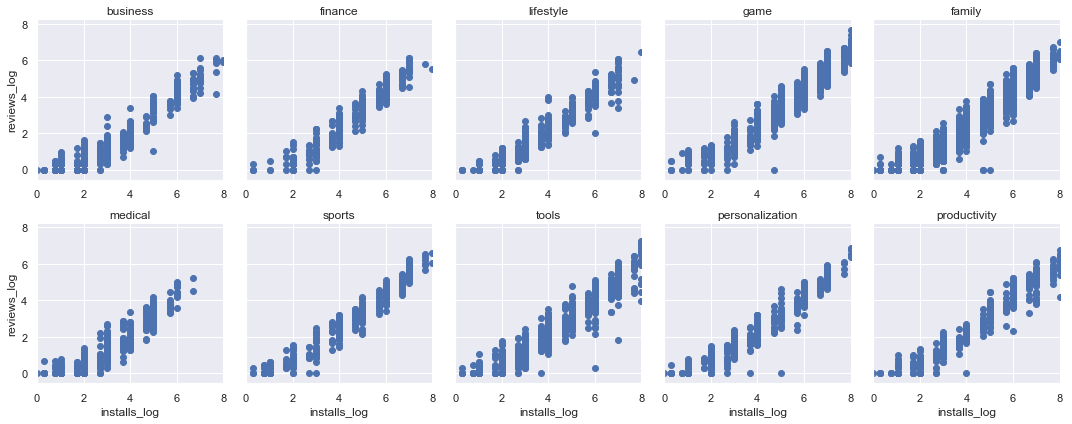

In [121]:
df_subset = df[df['category'].isin(top10_categories)]
g = sb.FacetGrid(df_subset, col='category', col_wrap=5, sharex=False)
g = (g.map(plt.scatter, 'installs_log', 'reviews_log')).set_titles('{col_name}').set(xlim=(0, 8))

- There is no significant difference between these categories.
- Positive correlation betweent `installs` and `reviews`.

## type & review & rating

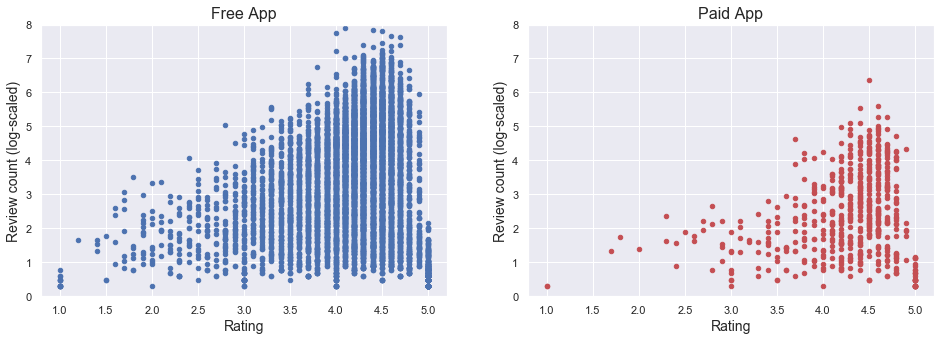

In [122]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 5)
df[df['price'] == 0].plot.scatter('rating', 'reviews_log', color='b', ax=ax1)
ax1.set_xlabel('Rating', fontsize=14)
ax1.set_ylabel('Review count (log-scaled)', fontsize=14)
ax1.set_ylim(0, 8)
ax1.set_title('Free App', fontsize=16)
df[df['price'] > 0].plot.scatter('rating', 'reviews_log', color='r', ax=ax2)
ax2.set_ylabel('Review count (log-scaled)', fontsize=14)
ax2.set_xlabel('Rating', fontsize=14)
ax2.set_ylim(0, 8)
ax2.set_title('Paid App', fontsize=16);

- There is no significant difference on how `rating` and `reviews` correlate
- Paid apps have less reivews than free apps. This is not surprising because people are more likely to install free apps

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!